# 探索的データ解析（EDA）

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/repos/signate-student-cup-2023/

/content/drive/MyDrive/repos/signate-student-cup-2023


## 1. ライブラリのインポート

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. データの読み込み

In [ ]:
path = Path.cwd()
train = pd.read_csv(path.joinpath("input", "train.csv"), index_col="id")
test = pd.read_csv(path.joinpath("input", "test.csv"), index_col="id")

In [ ]:
train.head()

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
id,,,,,,,,,,,,,,,
0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158


In [ ]:
test.head()

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
id,,,,,,,,,,,,,,
27532,western slope,2015,chevrolet,excellent,4 cylinders,gas,92553,clean,automatic,fwd,full-size,SUV,red,NaN
27533,roseburg,2013,nissan,like new,4 cylinders,gas,134385,salvage,automatic,fwd,mid-size,sedan,black,or
27534,akron / canton,2011,volkswagen,good,4 cylinders,gas,102489,clean,automatic,fwd,full-size,sedan,black,oh
27535,denver,2016,jeep,excellent,6 cylinders,diesel,64310,clean,automatic,4wd,mid-size,SUV,red,co
27536,hickory / lenoir,1999,honda,excellent,8 cylinders,gas,180839,rebuilt,automatic,4wd,mid-size,SUV,silver,nc


id順に並んだものを学習とテストに分割しているため、時系列データではなさそう。目で見た感じ、地域（region）の表記ゆれとかありそう。シリンダーの数（cylinders）は数値 + cylindersとなっているので、数値だけを抽出して数値変数へ変換できそう。

## 3. 変数の型をチェック

In [ ]:
train.dtypes

region          object
year             int64
manufacturer    object
condition       object
cylinders       object
fuel            object
odometer         int64
title_status    object
transmission    object
drive           object
size            object
type            object
paint_color     object
state           object
price            int64
dtype: object

In [ ]:
test.dtypes

region          object
year             int64
manufacturer    object
condition       object
cylinders       object
fuel            object
odometer         int64
title_status    object
transmission    object
drive           object
size            object
type            object
paint_color     object
state           object
dtype: object

学習データにおいて、数値変数は年式（year）と走行距離（odometer）のみで、その他がカテゴリ変数となっている。テストデータには、学習データから目的変数である価格（price）を除いた変数が存在している。

## 4. 変数の欠損値をチェック

In [ ]:
train.isnull().sum()

region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [ ]:
test.isnull().sum()

region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1495
odometer           0
title_status     229
transmission       0
drive              0
size               0
type             229
paint_color        0
state           3029
dtype: int64

見た目の状態（title_status）と車のタイプ（type）は、学習データとテストデータにおいて、欠損値の数が一致していることから何らかの関係がありそう。また、地域（region）と販売州（state）には一対一の関係が成り立っているため、欠損値の修正に利用できそう。

## 5. カテゴリ変数の種類数

In [ ]:
categorical_columns = [
    "region",
    "manufacturer",
    "condition",
    "cylinders",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

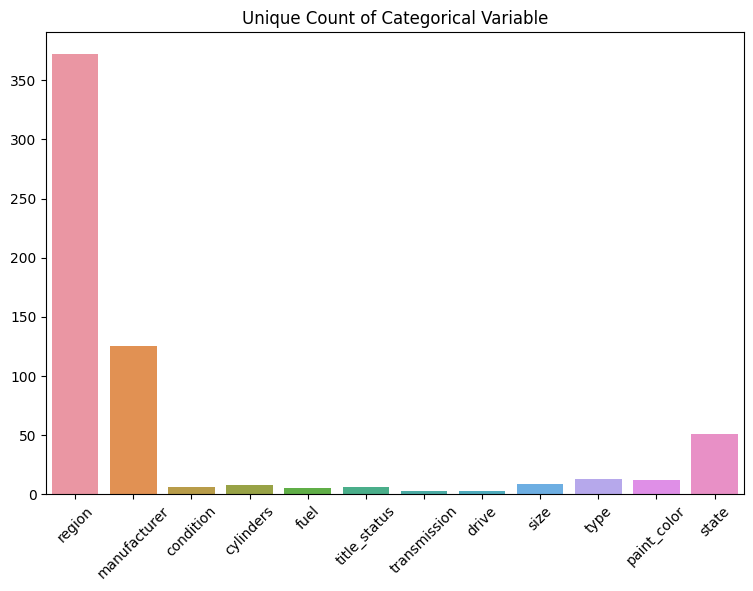

In [ ]:
unique_counts = [train[col].nunique() for col in categorical_columns]
fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(x=categorical_columns, y=unique_counts)
plt.xticks(rotation=45)
plt.title("Unique Count of Categorical Variable")
plt.show()

種類が一番多いのが地域（reigon）で、manufacture（製造社）やstate（販売州）は次いで多い。そのほかはどれも50種類未満なため、地域や製造社などの変数に比べて種類数に大きな差がある。Slackによると地域のような変数はノイズになり得るらしい。

## 6. 外れ値のチェック

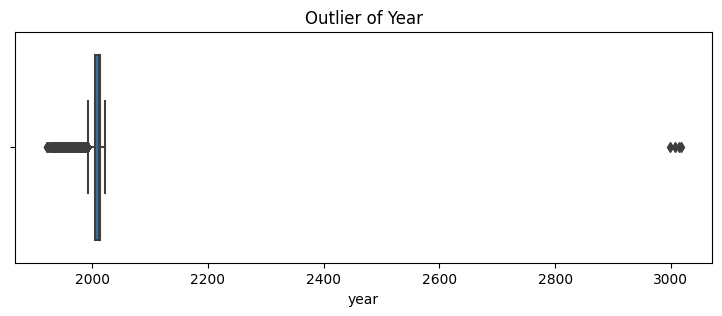

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(x=train["year"])
plt.title("Outlier of Year")
plt.show()

3000年付近に分布している年（year）は明らかに間違えているため、外れ値を修正（1000を引く）する必要がある。1900年～2000年の間も外れ値となっているが、製造年としてはあり得るので、そのまま利用する。

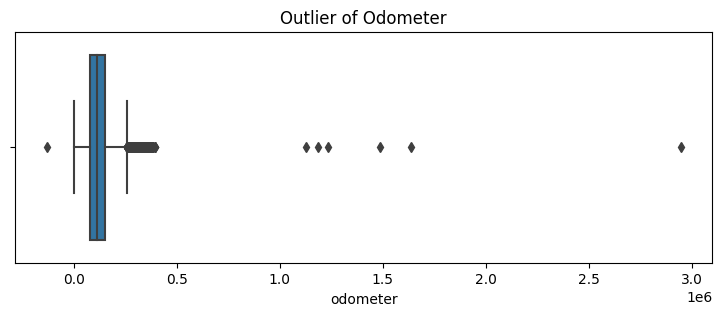

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3))
sns.boxplot(x=train["odometer"])
plt.title("Outlier of Odometer")
plt.show()

走行距離（odometer）において、負の数は外れ値とする。1e6以上の値も存在するが、低頻度であるためノイズになる可能性がある。ちなみに東京から10000kmの位置はニュージーランドやアメリカ合衆国辺りまでらしい。現実的じゃないため、外れ値として扱う。

## 7. 目的変数の分布

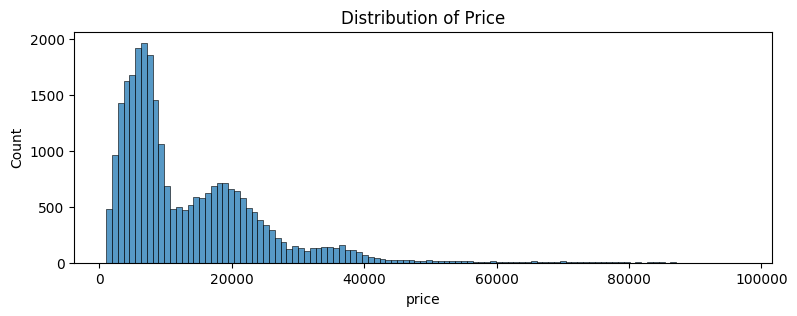

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3))
sns.histplot(x=train["price"], fill=True)
plt.title("Distribution of Price")
plt.show()

左側に偏った3つの峰からなる分布になっている。中古車ドメインということで比較的安めの自動車が多い。左に偏っている特徴からも目的変数に対して、対数をとったほうが良いかもしれない。

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27532 entries, 0 to 27531
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        27532 non-null  object
 1   year          27532 non-null  int64 
 2   manufacturer  27532 non-null  object
 3   condition     27532 non-null  object
 4   cylinders     27532 non-null  object
 5   fuel          26293 non-null  object
 6   odometer      27532 non-null  int64 
 7   title_status  27076 non-null  object
 8   transmission  27532 non-null  object
 9   drive         27532 non-null  object
 10  size          27532 non-null  object
 11  type          27076 non-null  object
 12  paint_color   27532 non-null  object
 13  state         24228 non-null  object
 14  price         27532 non-null  int64 
dtypes: int64(3), object(12)
memory usage: 3.4+ MB


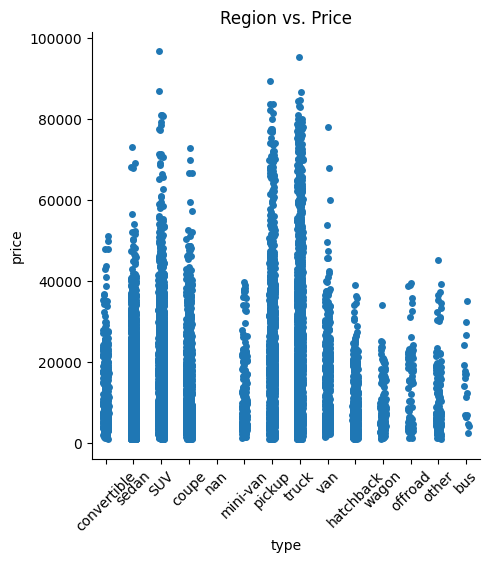

In [ ]:
sns.catplot(x=train["type"], y=train["price"])
plt.xticks(rotation=45)
plt.title("Region vs. Price")
plt.show()

## 8. 反省

*   odometerの-1は外れ値ではなく欠損値。
*   スタッキング時に元のデータの特徴量を加える必要があった。
*   MAPEの理解が必要。予測値に対する後処理が上位との差になった。（定数倍や加算）
*   1位の解法では、二つの峰のどちらに属するのかを2値分類を行い、その特徴量が2段目に効いた。
*   （その他）：EDAファイルでテーブルを作り、CVやLBの結果を管理する。

EDAで見るべきポイント（メモ）

統計量:
*   変数の平均/標準偏差/最大/最小/分位点
*   カテゴリ変数の種類数
*   変数の欠損値の数
*   変数間の相関係数

グラフ
*   棒グラフ
*   箱ひげ図、バイオリンプロット
*   散布図
*   折れ線グラフ
*   ヒートマップ
*   ヒストグラム
*   Q-Qプロット
*   t-SNE、UMAP